## PDFs of echo top height

In [17]:
from matplotlib import pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
from scipy import optimize, stats
from scipy.signal import argrelextrema

In [45]:
hist1_path = '/home/rjackson/data/echo_top_histograms1.cdf'
hist2_path = '/home/rjackson/data/echo_top_histograms2.cdf'
height_bins = np.arange(0, 20000, 500)
hist1_file = Dataset(hist1_path, mode='r')
hist2_file = Dataset(hist2_path, mode='r')
hist_break = hist2_file.variables['hist_break'][:]
hist_monsoon = hist2_file.variables['hist_monsoon'][:]
b_inds = argrelextrema(hist_break, np.greater)
m_inds = argrelextrema(hist_monsoon, np.greater)
print(b_inds[0])
print(height_bins[b_inds[0]])

[11 12 12 12 12 12 13 13 24 25 25 25 26 26 26 26]
[ 5500  6000  6000  6000  6000  6000  6500  6500 12000 12500 12500 12500
 13000 13000 13000 13000]


(0, 20)

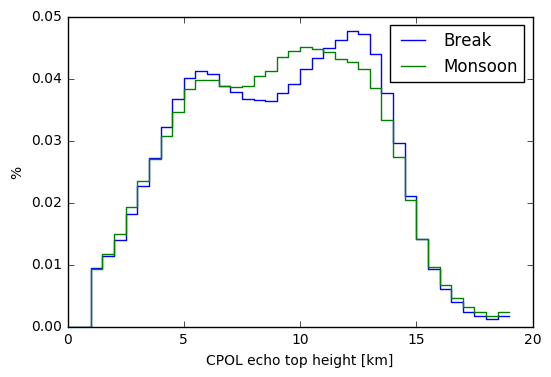

In [46]:
plt.step(height_bins[:-1]/1e3, np.sum(hist_break[:,:], axis=1)/np.sum(hist_break))
plt.step(height_bins[:-1]/1e3, np.sum(hist_monsoon[:,:], axis=1)/np.sum(hist_monsoon))
#plt.scatter(height_bins[b_inds[0]]/1e3, np.sum(hist_break[b_inds[0],:], axis=1)/np.sum(hist_break))
#plt.scatter(height_bins[m_inds[0]]/1e3, np.sum(hist_monsoon[m_inds[0],:], axis=1)/np.sum(hist_monsoon))
plt.legend(['Break', 'Monsoon'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([0, 20])

## Do multigaussian fits

In [63]:
def gaussian(x, center, width):
    return np.exp(-(x - center)**2/(2*width**2)) / (width*np.sqrt(2*np.pi))

def two_gaussians(x, c1, w1, c2, w2, A):
    return (A * gaussian(x, c1, w1) +
           (1 - A) * gaussian(x, c2, w2)) 

def three_gaussians(x, c1, w1, c2, w2, c3, w3, A, B):
    return (A * gaussian(x, c1, w1) +
            B * gaussian(x, c2, w2) + 
            (1 - A - B) * gaussian(x, c3, w3)) 
    
    
errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
errfunc3 = lambda p, x, y: (three_gaussians(x, *p) - y)**2

guess = [5, 1, 10, 1, 0.5]
guess3 = [5, 1, 10, 1, 15, 1, 0.3, 0.3]

fits_break3 = np.zeros((8, 8))
fits_monsoon3 = np.zeros((8, 8))
fits_break2 = np.zeros((5, 8))
fits_monsoon2 = np.zeros((5, 8))
chisquare_break3 = np.zeros(8)
chisquare_monsoon3 = np.zeros(8)
chisquare_break2 = np.zeros(8)
chisquare_monsoon2 = np.zeros(8)
for mjo_indicies in range(8):
    break_sum = np.sum(hist_break[:, mjo_indicies])/2
    monsoon_sum = np.sum(hist_monsoon[:, mjo_indicies])/2
    fits_break3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:, mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_break3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/break_sum, fexp)
    chisquare_break3[mjo_indicies] = p
    fits_monsoon3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_monsoon3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_monsoon3[mjo_indicies] = p
    fits_break2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:,mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_break2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_break2[mjo_indicies] = p
    fits_monsoon2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_monsoon2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_monsoon2[mjo_indicies] = p

In [60]:
plt.figure(figsize=(6,6))
print(chisquare_break3)
print(chisquare_monsoon3)
print(chisquare_break2)
print(chisquare_monsoon2)

[ 1.  1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.99761367  1.          1.          1.          1.          1.          1.
  0.78562433]
[ 1.  1.  1.  1.  1.  1.  1.  1.]


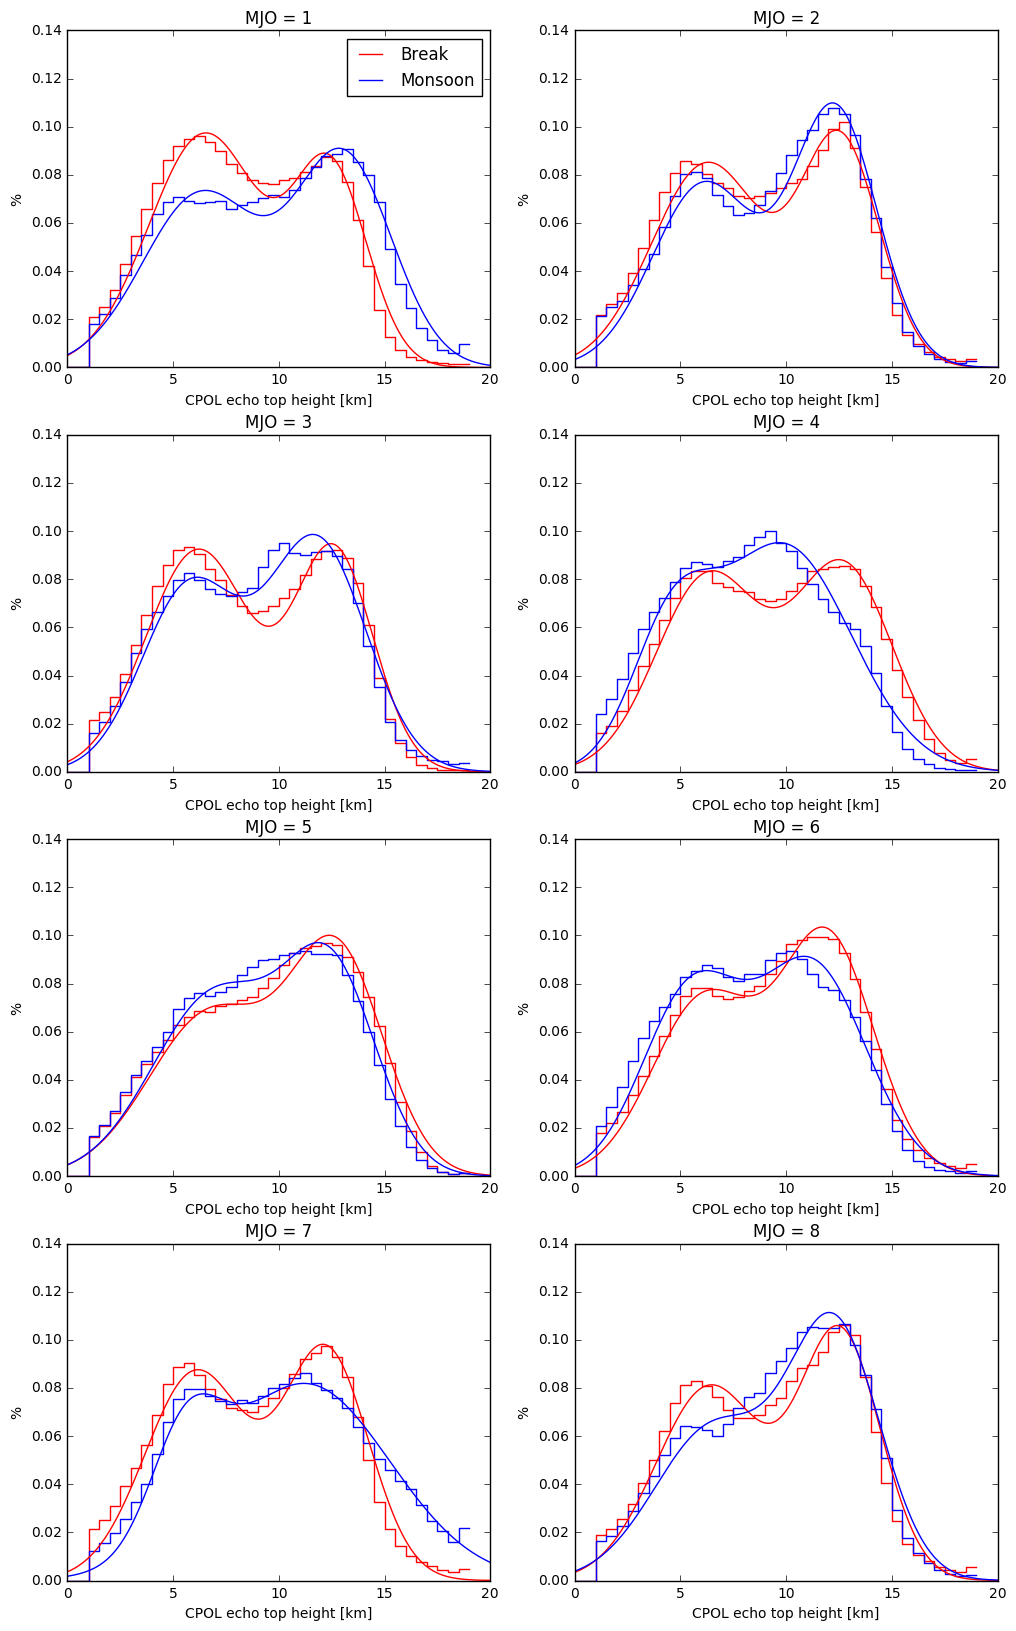

In [49]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,0]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,0]), color='b')
plt.legend(['Break', 'Monsoon'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,1]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,1]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,2]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,2]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,3]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,3]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,4]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,4]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,5]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,5]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,6]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,6]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,7]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,7]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 8')

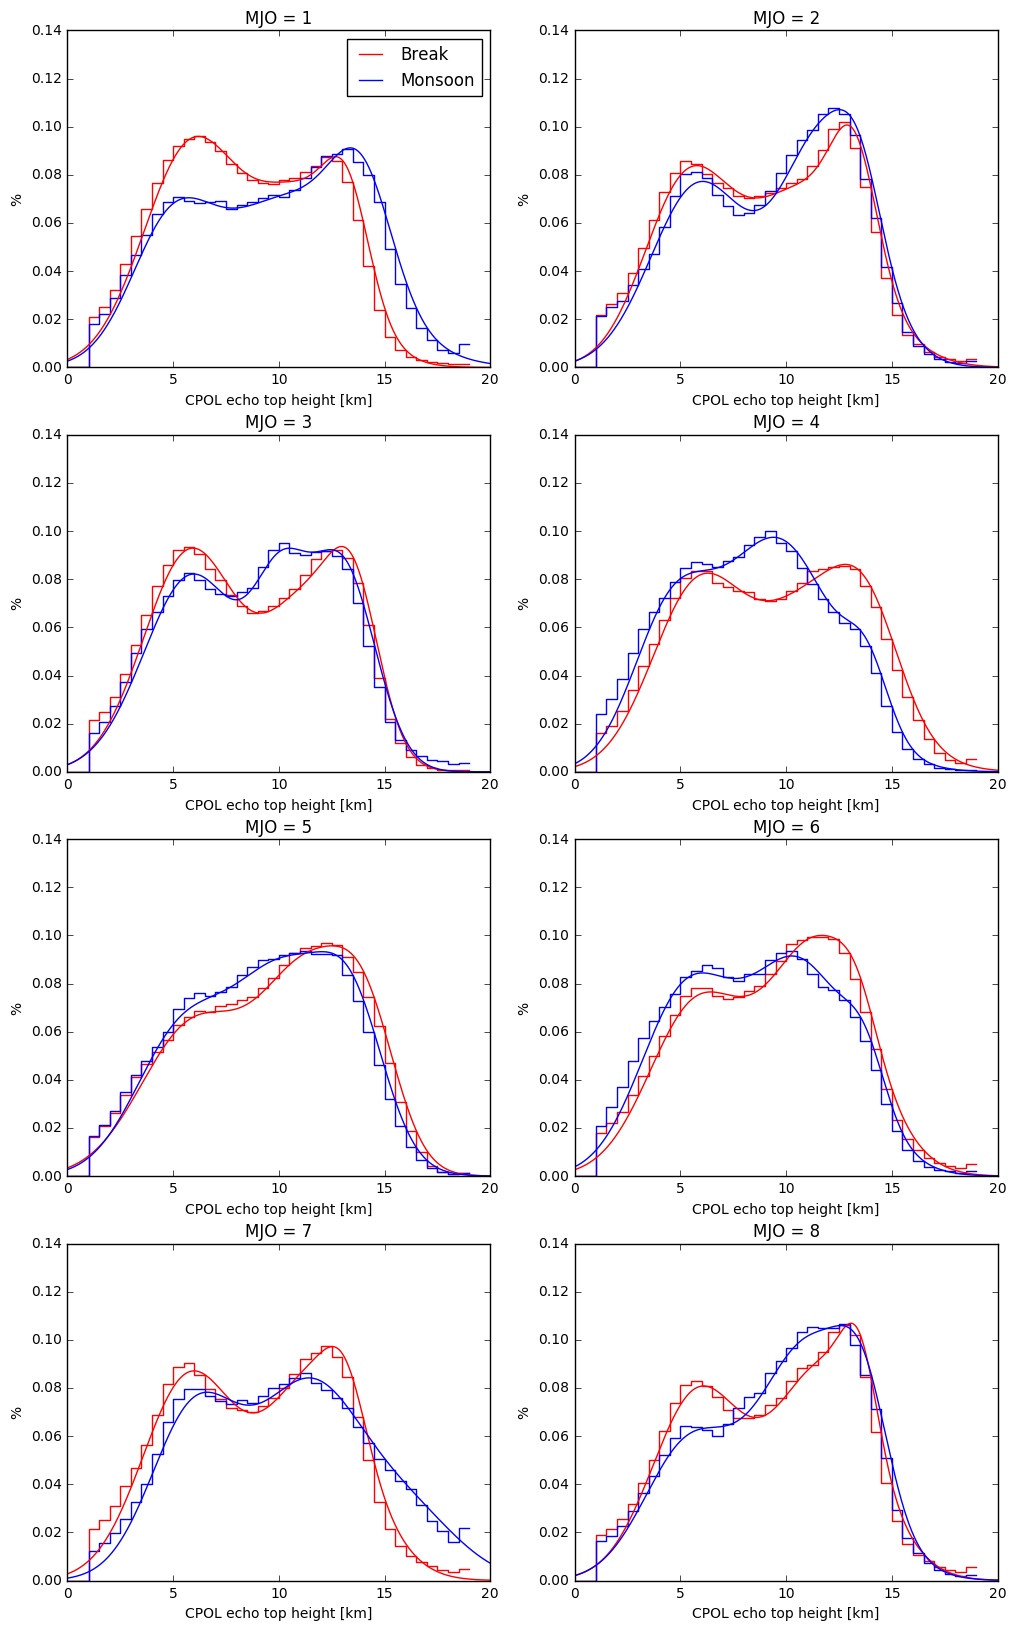

In [50]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,0]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,0]), color='b')
plt.legend(['Break', 'Monsoon'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,1]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,1]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,2]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,2]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,3]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,3]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,4]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,4]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,5]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,5]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,6]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,6]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,7]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,7]), color='b')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.14])
plt.title('MJO = 8')

In [10]:
from scipy import interpolate
def calc_percentile_from_hist(hist, bins, percent):
    cdf = np.cumsum(hist)/np.sum(hist)*100
    cdf_func = interpolate.interp1d(cdf, bins)
    return cdf_func(percent)

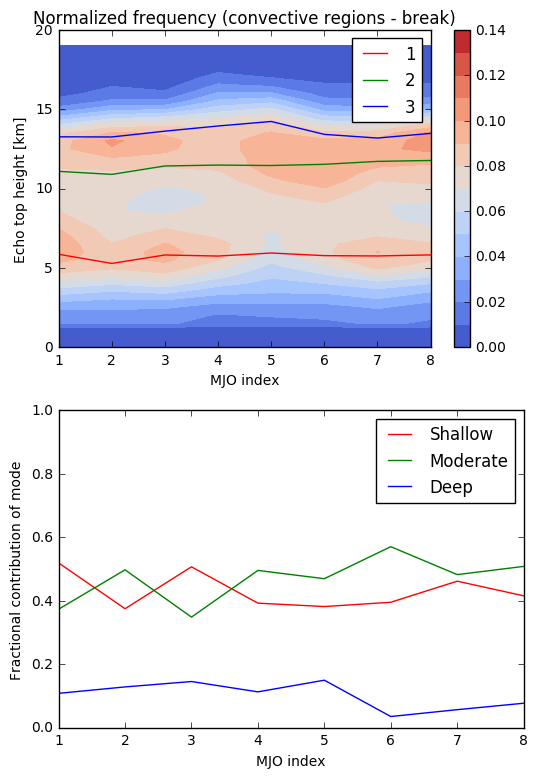

In [64]:
hist_mjo = hist_break
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
# Calculate percentiles
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,9))
plt.subplot(211)   
plt.contourf(mjos_2d, bins_2d, hist_mjo/np.sum(hist_mjo, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.15,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
plt.plot(np.arange(1,9), fits_break3[0,:], color = 'r', linestyle='-', label="1")
plt.plot(np.arange(1,9), fits_break3[2,:], color = 'g', linestyle='-', label="2")
plt.plot(np.arange(1,9), fits_break3[4,:], color = 'b', linestyle='-', label="3")
plt.legend()
plt.ylim([0,20])
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.title('Normalized frequency (convective regions - break)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_break3[6,:], label="Shallow", color='r')
plt.plot(np.arange(1,9), fits_break3[7,:], label="Moderate", color='g')
plt.plot(np.arange(1,9), 1-np.sum(fits_break3[6:8,:], axis=0), label="Deep", color= 'b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

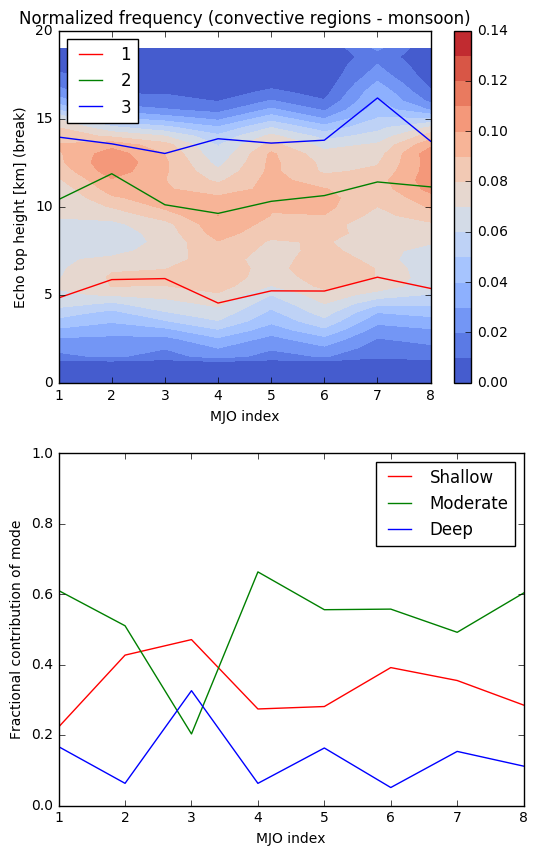

In [65]:
hist_mjo = hist_monsoon
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_monsoon/np.sum(hist_monsoon, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.15,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_monsoon3[0,:], color='r', linestyle='-', label="1")
plt.plot(np.arange(1,9), fits_monsoon3[2,:], color='g', linestyle='-', label="2")
plt.plot(np.arange(1,9), fits_monsoon3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km] (break)')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - monsoon)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_monsoon3[6,:], label="Shallow", color='r')
plt.plot(np.arange(1,9), fits_monsoon3[7,:], label="Moderate", color='g')
plt.plot(np.arange(1,9), 1-np.sum(fits_monsoon3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

In [ ]:
hist_mjo = hist_break+hist_monsoon
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.contourf(mjos_2d, bins_2d, hist_mjo/np.sum(hist_mjo, axis=0)*2,
             cmap='hot', levels=np.arange(0,0.15,0.01))
plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.title('Normalized frequency (stratiform regions - total)')
ax = plt.colorbar()